This tutorial contains ploting function for most major single cell analysis.

We use `Monocle2`'s `CellDataSet` object as the container for single-cell objects given it's advantages of:
1) Easy to store cell metadata (we will refer as **df_cell** throughout the tutorial), gene metadata (we will refer as **df_gene** throughout the tutorial), and gene count matrix (we will refer as **genecount** throughout the tutorial);
2) Easy to change the rownames of the gene count matrix - we will switch between **gene_id** (unique) and **gene_name** (containing duplicate names);
3) Easy to convert into `Seurat` and `SingleCellExperiment`objects.

For detailed tutorial of `Monocle2`, please refer: https://cole-trapnell-lab.github.io/monocle-release/docs/

Many plottings are achieved through `scCustomize` on `Seurat` object: https://samuel-marsh.github.io/scCustomize/index.html

For all the customized function used in this tutorial are saved as `RData` and uploaded into the github.

## Customized functions

In [45]:
# Function to construct a CellDataSet object from genecount, df_cell, and df_gene
cds_construct <- function (genecount, df_cell, df_gene) 
{
    # Ensure that both cell and gene data are data frames
    df_cell = as.data.frame(df_cell)
    df_gene = as.data.frame(df_gene)
    
    # Create AnnotatedDataFrame for phenotype (cell) and feature (gene) data
    pd = new("AnnotatedDataFrame", data = df_cell)
    fd = new("AnnotatedDataFrame", data = df_gene)
    
    # Set column name of genecount matrix as cell names
    # Set row name of genecount matrix as gene_id
    colnames(genecount) = df_cell$sample
    rownames(genecount) = df_gene$gene_id
    
    # Ensure row names of phenoData and featureData match genecount matrix
    rownames(pd) = colnames(genecount)
    rownames(fd) = rownames(genecount)
    
    # Create a CellDataSet object with negative binomial family for expression data
    cds = newCellDataSet(genecount, phenoData = pd, featureData = fd, 
        expressionFamily = negbinomial.size())
    
    return(cds) 
}
save(cds_construct, file = "/ru-auth/local/home/zzhang03/PanSci_tutorial/customized_function/cds_construct.RData")

In [47]:
# Function to convert a CellDataSet (cds) object to a Seurat object
cds_to_seu <- function (cds, rowname_col = "gene_short_name") 
{
    # Extract expression matrix, cell metadata (phenoData) and gene metadata (featureData) from cds
    genecount <- exprs(cds)
    df_cell <- pData(cds)
    df_gene <- fData(cds)
    
    # Use the specified rowname column (default "gene_short_name") to set rownames for the expression matrix
    rownames(genecount) <- make.names(df_gene[[rowname_col]], unique = TRUE)
    
    # Set column names of the expression matrix to the sample IDs from cell metadata
    colnames(genecount) <- df_cell$sample
    
    # Ensure rownames of the cell metadata match the sample IDs
    rownames(df_cell) <- df_cell$sample
    
    # Create Seurat object using the expression matrix and cell metadata
    seu <- CreateSeuratObject(counts = genecount, meta.data = df_cell)
    
    return(seu)
}
save(cds_to_seu, file = "/ru-auth/local/home/zzhang03/PanSci_tutorial/customized_function/cds_to_seu.RData")

In [55]:
# Function to plot labeled clusters on t-SNE or UMAP coordinates with customizable color palettes and options for labels
plot_labels_with_customized_palette <- function (labels, x, y, cell_size = 0.5, with_labels = TRUE, 
    custom_palette = NULL, label_font_size = 5, font_size = 6, show_legend = TRUE) 
{
    # Create a data frame combining cluster labels and t-SNE/UMAP coordinates
    df_cell <- data.frame(Cluster = labels, x_cor = x, y_cor = y)
    
    # Calculate the median position for each cluster to place the labels
    cluster_label <- df_cell %>% dplyr::group_by(Cluster) %>% 
        dplyr::summarise(mean_1 = median(x_cor), mean_2 = median(y_cor))
    
    # Use the provided custom color palette or default to discrete colors
    if (!is.null(custom_palette)) {
        palette <- scale_color_manual(values = custom_palette)
    } else {
        palette <- scale_color_discrete()
    }
    
    # Plot with or without cluster labels depending on 'with_labels'
    if (with_labels) {
        g1 <- ggplot() + 
            geom_point(data = df_cell, aes(x = x_cor, y = y_cor, color = Cluster), 
                       size = cell_size, stroke = 0, shape = 16, alpha = 1) + 
            ggrepel::geom_text_repel(aes(x = cluster_label$mean_1, y = cluster_label$mean_2, 
                                         label = cluster_label$Cluster), 
                                     size = label_font_size, max.overlaps = 200) + 
            xlab("") + ylab("") + 
            theme_void() +  # Removes background, axes, etc.
            guides(color = guide_legend(title = "", override.aes = list(size = 4, alpha = 1))) + 
            theme(legend.title = element_text(size = font_size), 
                  legend.text = element_text(size = font_size), 
                  legend.margin = margin(0, -10, 0, 10), 
                  legend.key.width = unit(0.15, "in"), 
                  legend.key.height = unit(0.15, "in"), 
                  legend.position = "left", 
                  text = element_text(size = font_size), 
                  plot.background = element_rect(fill = "transparent", color = NA)) + 
            palette
    } else {
        # Plot without cluster labels
        g1 <- ggplot() + 
            geom_point(data = df_cell, aes(x = x_cor, y = y_cor, color = Cluster), 
                       size = cell_size, stroke = 0, shape = 16, alpha = 1) + 
            xlab("") + ylab("") + 
            theme_void() + 
            guides(color = guide_legend(title = "", override.aes = list(size = 4, alpha = 1))) + 
            theme(legend.title = element_text(size = font_size), 
                  legend.text = element_text(size = font_size), 
                  legend.margin = margin(0, -10, 0, 10), 
                  legend.key.width = unit(0.15, "in"), 
                  legend.key.height = unit(0.15, "in"), 
                  legend.position = "left", 
                  text = element_text(size = font_size), 
                  plot.background = element_rect(fill = "transparent", color = NA)) + 
            palette
    }
    
    # Optionally hide the legend if 'show_legend' is FALSE
    if (!show_legend) {
        g1 <- g1 + theme(legend.position = "none")
    }
    
    return(g1)  # Return the final ggplot object
}
save(plot_labels_with_customized_palette, file = "/ru-auth/local/home/zzhang03/PanSci_tutorial/customized_function/plot_labels_with_customized_palette.RData")

In [103]:
# Function to aggregate gene expression by cell type
cds_aggregate_by_type <- function (cds, types) {
    # Get unique types of cells
    unique_types = unique(types)
    
    # Aggregate cell counts by the specified cell types
    agg_cell_count = t(Matrix.utils::aggregate.Matrix(t(exprs(cds)), as.factor(types)))
    
    # Update column names to match the aggregated cell types
    colnames(agg_cell_count) = as.character(colnames(agg_cell_count))
    
    # Create a data frame for cell metadata
    df_cell = data.frame(sample = colnames(agg_cell_count))
    
    # Get the gene metadata from the original cds
    df_gene = fData(cds)
    
    # Reconstruct the cds object with the aggregated cell counts
    cds = cds_construct(agg_cell_count, df_cell, df_gene)
    
    return(cds)  # Return the updated CellDataSet
}
save(cds_aggregate_by_type, file = "/ru-auth/local/home/zzhang03/PanSci_tutorial/customized_function/cds_aggregate_by_type.RData")

In [105]:
# Function to extract and normalize gene expression for a specific cell type
cds_cell_type_exprs <- function (cds, cell_type) {
    # Aggregate the cds object by the specified cell type
    cds_agg = cds_aggregate_by_type(cds, cell_type)
    
    # Extract the gene expression matrix from the aggregated cds
    genecount = exprs(cds_agg)
    
    # Normalize the expression matrix by the column sums and scale it
    genecount = t(t(genecount) / colSums(genecount)) * 1e+05
    
    # Log-transform the normalized expression
    genecount = log(genecount + 1)
    
    # Update the column names to match the aggregated samples
    colnames(genecount) = cds_agg$sample
    
    return(genecount)  # Return the normalized gene expression matrix
}
save(cds_cell_type_exprs, file = "/ru-auth/local/home/zzhang03/PanSci_tutorial/customized_function/cds_cell_type_exprs.RData")

In [173]:
# Function to calculate the proportion of each cell type in each sample
cds_cell_count_proportion_matrix <- function(cds) {
    # Create a diagonal matrix where each element is the inverse of the column sums of the expression matrix
    b = Matrix::Diagonal(x = 1 / colSums(exprs(cds)))
    
    # Multiply the expression matrix by this diagonal matrix to normalize by column sums (sample total counts)
    return(exprs(cds) %*% b)
}
save(cds_cell_count_proportion_matrix, file = "/ru-auth/local/home/zzhang03/PanSci_tutorial/customized_function/cds_cell_count_proportion_matrix.RData")

In [174]:
# Function to calculate the mean proportion of each cell type across samples belonging to different classes
cds_cell_count_class_mean <- function(cds, class_vector) {
    # Calculate the proportion matrix using the previous function
    cds_express <- cds_cell_count_proportion_matrix(cds)
    
    # Get the unique classes from the class_vector, sorted
    unique_class <- sort(unique(class_vector))
    
    # Calculate the mean proportion for each class
    tmp_class_means <- lapply(1:length(unique_class), function(x) {
        # If there is more than one sample in the class, compute the row-wise mean for those samples
        if (sum(class_vector == unique_class[x]) > 1) {
            result = Matrix::rowMeans(cds_express[, class_vector == unique_class[x]])
        } 
        # If there is only one sample in the class, use the expression values directly
        else {
            result = cds_express[, class_vector == unique_class[x]]
        }
        return(result)
    })
    
    # Combine the results into a matrix with one column per class
    tmp_class_means <- do.call(cbind, tmp_class_means)
    
    # Set the column names as the unique class names
    colnames(tmp_class_means) = unique_class
    
    # Return the matrix of mean proportions for each class
    return(tmp_class_means)
}
save(cds_cell_count_class_mean, file = "/ru-auth/local/home/zzhang03/PanSci_tutorial/customized_function/cds_cell_count_class_mean.RData")

## Load libraries

In [257]:
suppressMessages(library(monocle))
suppressMessages(library(Seurat))
suppressMessages(library(cowplot))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(scCustomize))
suppressMessages(library(ggtext))
suppressMessages(library(pheatmap))
suppressMessages(library(purrr))
suppressMessages(library(stringr))
suppressMessages(library(ggalluvial))

In [185]:
input_folder <-  "/ru-auth/local/home/zzhang03/PanSci_tutorial/sample_data/"

In [273]:
## load color palette
load(file.path(input_folder,"../PanSci_Color_Palette.RData"))

### Read into cds

In [36]:
genecount <- Matrix::readMM(file.path(input_folder, "genecount.mtx"))

In [37]:
dim(genecount)

[1] 55416 16000

In [38]:
df_cell <- read.csv(file.path(input_folder, "df_cell.csv"), row.names = NULL)
df_gene <- read.csv(file.path(input_folder, "df_gene.csv"), row.names = NULL)

In [40]:
cds <- cds_construct(genecount, df_cell, df_gene)

In [41]:
cds

CellDataSet (storageMode: environment)
assayData: 55416 features, 16000 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames:
    20230221_EXP096_128_ATCCTGCTAG_Plate_2_AAGCATCCTA_CAGCTATCGT
    20221205_EXP096_94_GGTAGAATAT_Plate_1_TGAGTCTGGC_TCTTGCCGAC ...
    20230221_EXP096_184_CAGCGTCCAA_Plate_4_CCTCCTTCAT_CCGGCGCATT (16000
    total)
  varLabels: X sample ... ID (19 total)
  varMetadata: labelDescription
featureData
  featureNames: ENSMUSG00000102693.2 ENSMUSG00000064842.3 ...
    ENSMUSG00000095041.8 (55416 total)
  fvarLabels: X gene_id gene_type gene_short_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [43]:
## Cell metadata - pData(cds)
t(head(pData(cds)))

,20230221_EXP096_128_ATCCTGCTAG_Plate_2_AAGCATCCTA_CAGCTATCGT,20221205_EXP096_94_GGTAGAATAT_Plate_1_TGAGTCTGGC_TCTTGCCGAC,20221205_EXP096_43_GCCTATATTG_Plate_1_AACTAGGCGC_CGTCGCAGCC,20221205_EXP096_19_TTGAACTAAG_Plate_1_TTACCTCGAC_TTGCTGGCAT,20230221_EXP096_185_CGGACTGGCC_Plate_4_AGAGGCTCGT_ACTCCGTACC,20230221_EXP096_029_CTGAACCGCA_Plate_2_AATACCAGTT_CGGAGATCCG
X,20230221_EXP096_128_ATCCTGCTAG_Plate_2_AAGCATCCTA_CAGCTATCGT,20221205_EXP096_94_GGTAGAATAT_Plate_1_TGAGTCTGGC_TCTTGCCGAC,20221205_EXP096_43_GCCTATATTG_Plate_1_AACTAGGCGC_CGTCGCAGCC,20221205_EXP096_19_TTGAACTAAG_Plate_1_TTACCTCGAC_TTGCTGGCAT,20230221_EXP096_185_CGGACTGGCC_Plate_4_AGAGGCTCGT_ACTCCGTACC,20230221_EXP096_029_CTGAACCGCA_Plate_2_AATACCAGTT_CGGAGATCCG
sample,20230221_EXP096_128_ATCCTGCTAG_Plate_2_AAGCATCCTA_CAGCTATCGT,20221205_EXP096_94_GGTAGAATAT_Plate_1_TGAGTCTGGC_TCTTGCCGAC,20221205_EXP096_43_GCCTATATTG_Plate_1_AACTAGGCGC_CGTCGCAGCC,20221205_EXP096_19_TTGAACTAAG_Plate_1_TTACCTCGAC_TTGCTGGCAT,20230221_EXP096_185_CGGACTGGCC_Plate_4_AGAGGCTCGT_ACTCCGTACC,20230221_EXP096_029_CTGAACCGCA_Plate_2_AATACCAGTT_CGGAGATCCG
Cell_name,20230221_EXP096_128_ATCCTGCTAG_Plate_2_AAGCATCCTA_CAGCTATCGT,20221205_EXP096_94_GGTAGAATAT_Plate_1_TGAGTCTGGC_TCTTGCCGAC,20221205_EXP096_43_GCCTATATTG_Plate_1_AACTAGGCGC_CGTCGCAGCC,20221205_EXP096_19_TTGAACTAAG_Plate_1_TTACCTCGAC_TTGCTGGCAT,20230221_EXP096_185_CGGACTGGCC_Plate_4_AGAGGCTCGT_ACTCCGTACC,20230221_EXP096_029_CTGAACCGCA_Plate_2_AATACCAGTT_CGGAGATCCG
Genotype,WT,WT,WT,WT,WT,WT
Sex,Male,Male,Female,Male,Male,Male
Age_group,12_months,06_months,06_months,06_months,03_months,12_months
UMI_count,2264,674,1782,346,1149,993
Gene_count,1151,428,1006,164,595,603
Organ_name,Kidney,Kidney,Kidney,Kidney,Kidney,Kidney
Main_umap_1,2.0824840,2.6053934,3.6768348,2.7362840,3.1719477,0.2499491


In [44]:
## Gene metadata - fData(cds)
t(head(fData(cds)))

,ENSMUSG00000102693.2,ENSMUSG00000064842.3,ENSMUSG00000051951.6,ENSMUSG00000102851.2,ENSMUSG00000103377.2,ENSMUSG00000104017.2
X,1,2,3,4,5,6
gene_id,ENSMUSG00000102693.2,ENSMUSG00000064842.3,ENSMUSG00000051951.6,ENSMUSG00000102851.2,ENSMUSG00000103377.2,ENSMUSG00000104017.2
gene_type,TEC,snRNA,protein_coding,processed_pseudogene,TEC,TEC
gene_short_name,4933401J01Rik,Gm26206,Xkr4,Gm18956,Gm37180,Gm37363


### Convert cds into seu

In [51]:
seu <- cds_to_seu(cds, rowname_col = "gene_short_name")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [52]:
seu

An object of class Seurat 
55416 features across 16000 samples within 1 assay 
Active assay: RNA (55416 features, 0 variable features)
 2 layers present: counts, data

### Seuart basics

In [86]:
seu$Main_cell_type <- factor(seu$Main_cell_type, levels = sort(unique(seu$Main_cell_type)))

In [87]:
Idents(seu) <- seu$Main_cell_type

In [76]:
seu <- NormalizeData(object = seu)
seu <- FindVariableFeatures(object = seu, nfeatures = 3000)
seu <- ScaleData(object = seu)
seu <- RunPCA(object = seu, npcs = 50)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -3.9031”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.4811e-15”
Centering and scaling data matrix

PC_ 1 
Positive:  Slc27a2, Lrp2, Fut9, Gm42397, Hnf4aos, Kcnj15, Cubn, Abcc2, Dab2, Slc34a1 
	   Keg1, Gk, Them7, Slc4a4, Slc47a1, Gcnt1, Slc25a21, Slc17a3, Pter, Hgd 
	   Nhs, Acsm2, Slco1a6, Ghr, Arhgap42, Cyp2j5, Snx29, Pdzk1, Fggy, Bnc2 
Negative:  Abca13, Cacnb4, Ldb2, Prkg1, Meis2, Slc8a1, Phactr1, Ebf1, Egf, Tshz2 
	   Efna5, Slc12a3, Tmem117, Rbms3, Dlc1, Erbb4, Plpp1, Tox3, Prkd1, Slc5a3 
	   Slc12a1, Umod, Cadps2, Fbxl7, Cald1, Nbea, Cacnb2, Flt1, Ptprb, Prkch 
PC_ 2 
Positive:  Prkg1, Pde3a, Cfh, Lama2, Tshz2, Csmd1, Fbln5, Gpc6, Dlc1, Robo2 
	   Zeb2, Ldb2, Cald1, X4930578

In [66]:
## Add dimension reduction to seu
tmp_umap <- seu@meta.data %>% dplyr::select(Main_umap_1, Main_umap_2) %>% as.matrix()
colnames(tmp_umap) <- paste0("UMAP_", 1:2)
seu[["umap"]] <- CreateDimReducObject(embeddings = tmp_umap, key = "UMAP_", assay = DefaultAssay(seu))

For more details - refer: https://satijalab.org/seurat/archive/v3.0/dim_reduction_vignette.html

### Define other variables

In [90]:
cell_type_colors <- c(
  "Adipocytes" = "#ffb75b",
  "Ascending thin limb of LOH cells" = "#003490",
  "Connecting tubule cells" = "#0387e7",
  "Descending thin limb of LOH cells" = "#34a0ff",
  "Distal convoluted tubule cells" = "#85d95f",
  "Fibroblasts" = "#f05b26",
  "Juxtaglomerular cells" = "#faac38",
  "Lgr5 positive cells" = "#cd63ea",
  "Lymphatic endothelial cells" = "#fa74f7",
  "Lymphoid cells_B cells" = "#017ace",
  "Lymphoid cells_Plasma cells" = "#017ace",
  "Lymphoid cells_T cells" = "#017ace",
  "Macula densa cells" = "#a11640",
  "Megf11 positive cells" = "#ff5ed7",
  "Myeloid cells" = "#009b3c",
  "Myeloid cells_Dendritic cells" = "#009b3c",
  "Ncam1 positive cells" = "#636cf7",
  "Podocytes" = "#6ac532",
  "Principal cells" = "#00652f",
  "Proximal tubule cells" = "#02b973",
  "Thick ascending limb of LOH cells" = "#dd95ac",
  "Type A intercalated cells" = "#c50c19",
  "Type B intercalated cells" = "#e4005b",
  "Urothelial cells" = "#ac0097",
  "Vascular endothelial cells" = "#ffabbb"
)


In [91]:
cell_markers <- c(
    ## Adipocytes
    "Plin1", "Adipoq",
    ## Ascending thin limb of LOH cells
    "Epha7", "Cfap52",
    ## Connecting tubule cells
    "Egfem1", "Slc2a9",
    ## Descending thin limb of LOH cells
    "Cdh13", "Fst",
    ## Distal convoluted tubule cells
    "Slc12a3", "Trpm6",
    ## Fibroblasts
    "Pdgfra","Col6a3",
    ## Juxtaglomerular cells
    "Rgs5", "Dgkb",
    ## Lgr5 positive cells
    "Lgr5", "Sox17",
    ## Lymphatic endothelial cells
    "Mmrn1", "Stab2",
    ## B cells
    "Pax5", "Ms4a1",
    ## Plasma cells
    "Jchain", "Igkc",
    ## T cells
    "Itk", "Cd247",
    ## Macula densa cells
    "Nos1","Enox1",
    ## Megf11 positive cells
    "Megf11", "Nrip3",
    ## Myeloid cells
    "Adgre1", "Lyz2",
    ## Myeloid cells_Debdritic cells
    "Flt3", "Clec9a",
    ## Ncam1 positive cells
    "Ncam1", "Kcnmb2",
    ## Podocytes
    "Nphs1", "Lingo2",
    ## Principal cells
    "Aqp2", "Dab1",
    ## Proximal tubule cells
    "Lrp2", "Slc13a3",
    ## Thick ascending limb cells of LOH
    "Slc2a13", "Tmem207",
    ## Type A intercalated cells
    "Kit", "Aqp6",
    ## Type B intercalated cells
    "Slc26a4", "Hmx2",
    ## Urothelial cells
    "Upk1b", "Capn13",
    ## Vascular endothelial cells
    "Exoc3l2", "Ednrb"
)

## Plotting function

### Cellular level analysis

#### UMAP visualization of cell metadata

In [53]:
dim(df_cell)

[1] 16000    19

In [54]:
shuffled_df_cell <- df_cell[sample(nrow(df_cell)), ]

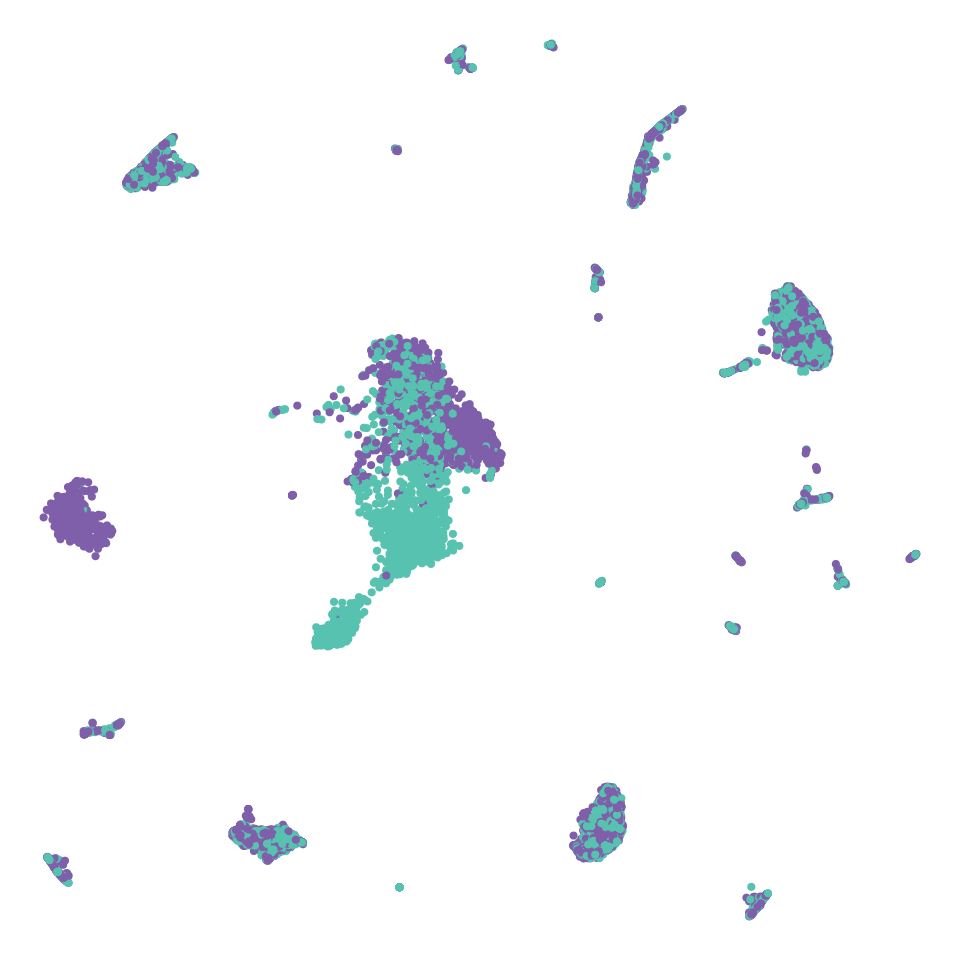

In [61]:
df_plot <- shuffled_df_cell
g1 <- plot_labels_with_customized_palette(labels = shuffled_df_cell$Sex, 
                                          x = shuffled_df_cell$Main_umap_1, 
                                          y = shuffled_df_cell$Main_umap_2,
                                          cell_size = 2,
                                          with_labels = F, 
                                          custom_palette = c("Female" = "#7f5fa9", "Male" = "#57c2b0"), 
                                          label_font_size = 5, 
                                          font_size = 6,
                                          show_legend = F)
options(repr.plot.width = 8, repr.plot.height = 8)
g1

#### UMAP visualization of targeted label

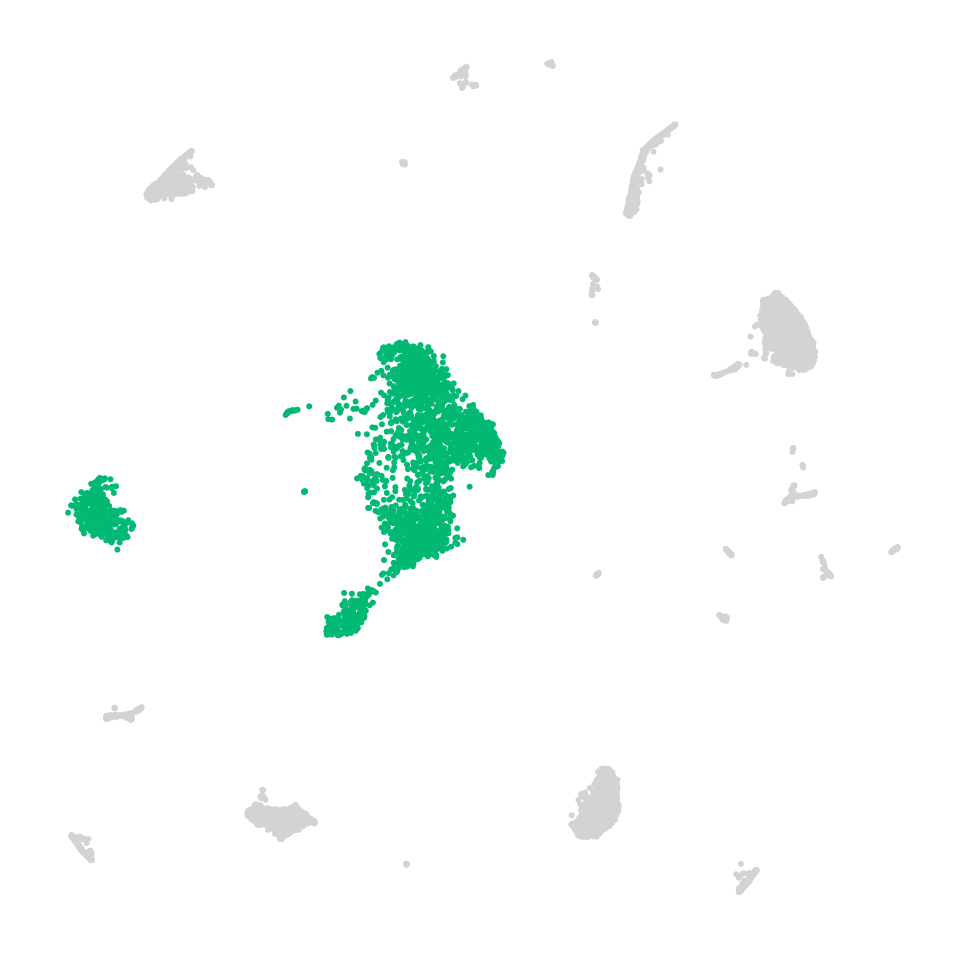

In [71]:
g1 <- Meta_Highlight_Plot(seurat_object = seu, 
                    meta_data_column = "Main_cell_type",
                    meta_data_highlight = "Proximal tubule cells", 
                    highlight_color = "#02b973", 
                    background_color = "lightgray")+
    theme_cowplot() +
    theme(plot.title = element_text(hjust = 0.5),
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank(),
          legend.position = "none")
options(repr.plot.width = 8, repr.plot.height = 8)
g1

#### UMAP visualization of cell density

Warning message:
“The dot-dot notation (`..level..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(level)` instead.”


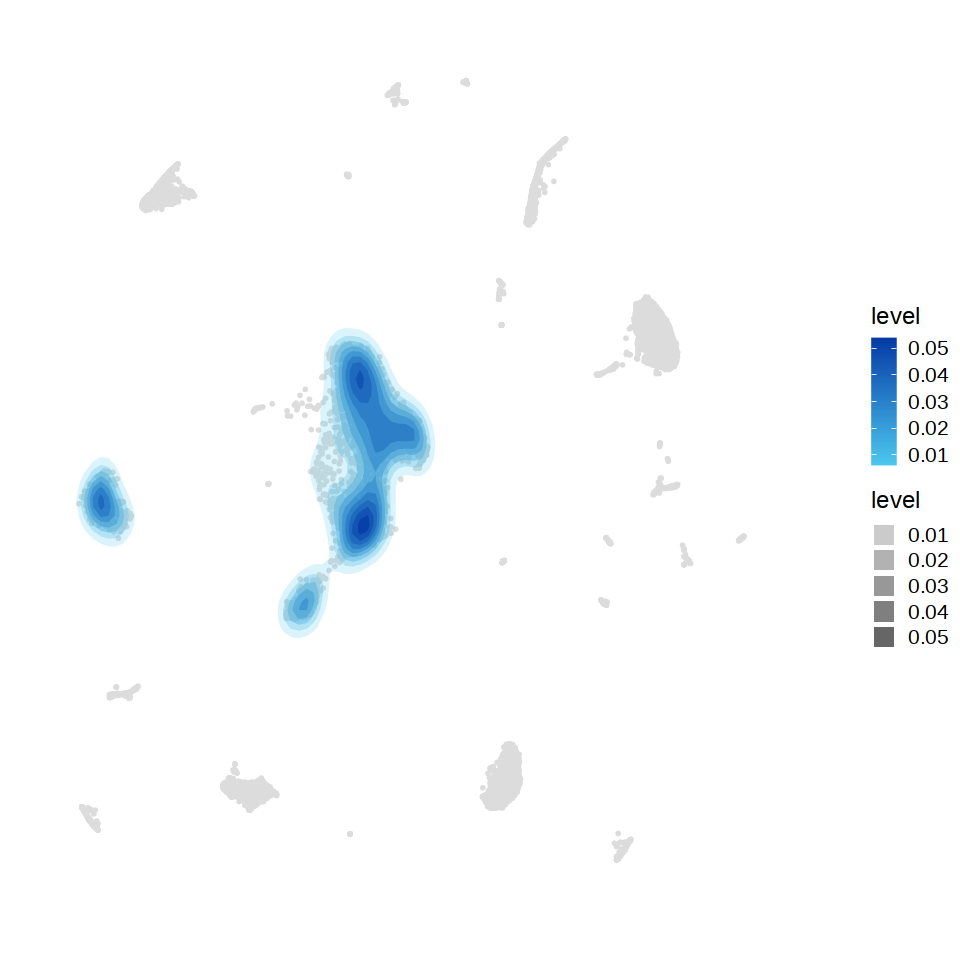

In [75]:
df_plot = df_cell
g1 <- ggplot(data = NULL)+
    geom_point(data = df_plot, size = 1, aes(x=Main_umap_1, y=Main_umap_2), color = "#DCDCDC",shape=16) +
    stat_density2d(data = df_plot %>% filter(Main_cell_type %in% c("Proximal tubule cells")), ## filter by label of interest
                 aes(x=Main_umap_1,y=Main_umap_2, alpha=..level.., fill=..level..), 
                 contour_var = 'density', size=2, bins=10, geom='polygon') + 
    scale_fill_gradientn(colours = colorRampPalette(c("#4DC8EF", "#053BA6"))(100))+
    scale_alpha_continuous(range=c(0.2,0.8)) + 
    xlim(min(df_plot$Main_umap_1)-1 ,max(df_plot$Main_umap_2)+1) +
    ylim(min(df_plot$Main_umap_1)-1 ,max(df_plot$Main_umap_2)+1) +
    theme_cowplot() +
    theme(plot.title = element_text(hjust = 0.5),
        axis.title = element_blank(), axis.text = element_blank(),
        axis.ticks = element_blank(), axis.line = element_blank())
options(repr.plot.width = 8, repr.plot.height = 8)
g1

#### Box plot for for cell proportion

In [171]:
## output from the DA analysis pipeline
cds_list = readRDS(file.path(input_folder,"cds_normalized_cell_count_sub.RDS"))

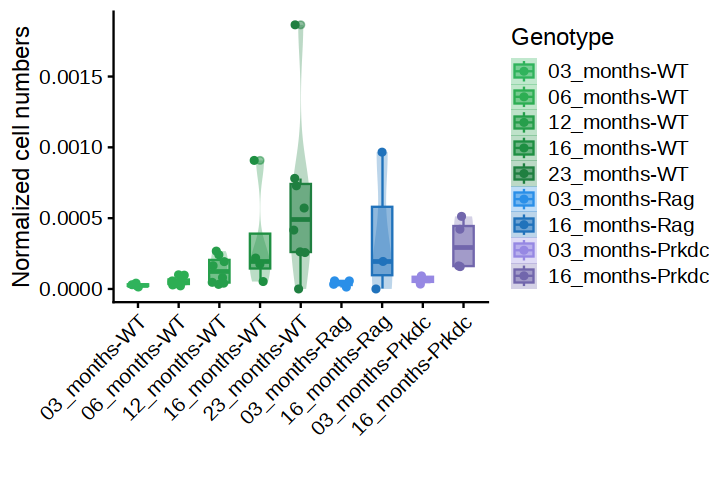

In [186]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot_aging_prop(cds_list, target_organ = '02_Lung', target_cell_type = "Fibroblasts-25-Lung")

#### Heatmap for cell proportion across experimental condition (aggregated proportion)

In [212]:
df_plot <- read.csv(file.path(input_folder, "df_aging_associated_cell_heatmap.csv"), row.names = 1)

In [213]:
head(df_plot)

,X03_months,X06_months,X12_months,X16_months,X23_months
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rdh16 positive cells-5-gWAT,0.0018644911,8.311299e-04,3.925152e-04,7.405807e-04,1.009755e-04
Enteric glia-2-Ileum,0.0007613312,3.796868e-04,2.700497e-04,3.358831e-04,1.786259e-04
Principal cells-14-Kidney,0.0001635165,1.031714e-04,9.003872e-05,7.976048e-05,3.577404e-05
Tenocytes-1-Muscle,0.0046107585,2.842186e-03,2.185764e-03,2.304283e-03,9.631666e-04
Adipocytes-4-Colon,0.0009286197,2.988723e-04,3.151687e-05,1.061017e-04,9.377258e-05
Adipocytes-6-Ileum,0.0001647112,5.353191e-05,5.691649e-06,2.337704e-05,1.504816e-05


In [214]:
## Z-scaled the proportion
scaled_mat <- t(apply(df_plot, 1, scale))

In [215]:
colnames(scaled_mat) <- c("03_months", "06_months", "12_months", "16_months", "23_months")

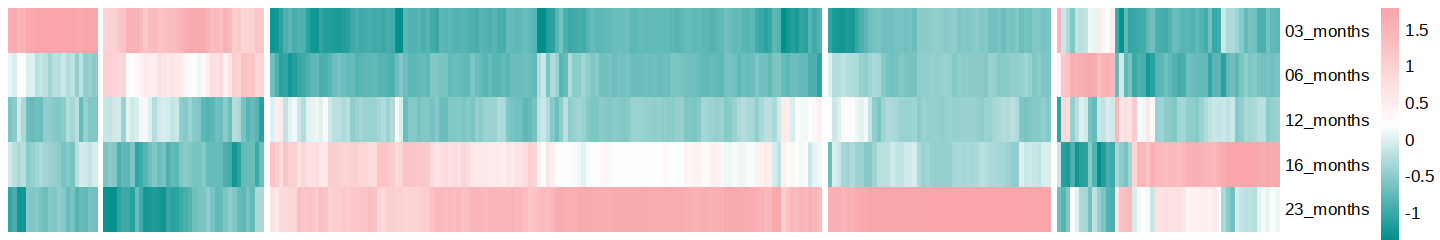

In [216]:
options(repr.plot.width = 12, repr.plot.height = 2)
g1 <- pheatmap(t(scaled_mat), 
                show_rownames = T,
                show_colnames = F,
                scale="none",
                gaps_col = c(20, 56, 180, 230),
                cluster_cols = FALSE,
                cluster_rows = FALSE,
                color= colorRampPalette(c("#008F8C", "white","#F9A5A9"))(100),
)

#### Heatmap for cell proportion across experimental condition (by replicate)

In [218]:
df_plot <- read.csv(file.path(input_folder, "df_aging_associated_cell_heatmap_individual.csv"), row.names = 1)

In [219]:
head(df_plot)

,Immunodeficient.03_months.Female.WT_1,Immunodeficient.03_months.Female.WT_2,Immunodeficient.03_months.Male.WT_1,Immunodeficient.03_months.Male.WT_2,Aging.06_months.Female.WT_1,Aging.06_months.Female.WT_2,Aging.06_months.Female.WT_3,Aging.06_months.Female.WT_4,Aging.06_months.Male.WT_1,Aging.06_months.Male.WT_2,⋯,Immunodeficient.16_months.Male.WT_1,Immunodeficient.16_months.Male.WT_2,Aging.23_months.Female.WT_1,Aging.23_months.Female.WT_2,Aging.23_months.Female.WT_3,Aging.23_months.Female.WT_4,Aging.23_months.Male.WT_1,Aging.23_months.Male.WT_2,Aging.23_months.Male.WT_3,Aging.23_months.Male.WT_4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rdh16 positive cells-5-gWAT,0.000000000,0.000000000,0.002881738,0.004576226,0.000039900,0.000124347,0.000105876,0.000000000,0.002157980,0.001620169,⋯,0.000153817,0.002430815,0.000000000,0.000000000,0.000000000,0.000000000,0.000131320,0.000000000,0.000309954,0.000366531
Enteric glia-2-Ileum,0.000578884,0.000255820,0.001034989,0.000875942,0.000317881,0.000217782,0.000529585,0.000074000,0.001029245,0.000157386,⋯,0.000654343,0.000278422,0.000000000,0.000343525,0.000059100,0.000123400,0.000360211,0.000136173,0.000276033,0.000130554
Principal cells-14-Kidney,0.000185354,0.000197090,0.000142931,0.000128692,0.000123278,0.000086400,0.000071200,0.000157787,0.000037000,0.000125353,⋯,0.000010400,0.000077400,0.000043600,0.000040900,0.000049000,0.000061200,0.000029800,0.000026700,0.000023600,0.000011400
Tenocytes-1-Muscle,0.005713844,0.006148127,0.001948201,0.004632862,0.002326393,0.002773498,0.002901880,0.006475774,0.002957524,0.001005811,⋯,0.002433476,0.001660694,0.000835522,0.001418228,0.001276638,0.001337137,0.000482684,0.000915290,0.000696304,0.000743531
Adipocytes-4-Colon,0.000208024,0.000172004,0.000413893,0.000540054,0.000215790,0.000172259,0.000136295,0.000206882,0.000068500,0.000278901,⋯,0.000000000,0.000000000,0.000104011,0.000101541,0.000027800,0.000022700,0.000029800,0.000031400,0.000110084,0.000322806
Adipocytes-6-Ileum,0.000133589,0.000255820,0.000133547,0.000150161,0.000053000,0.000217782,0.000048100,0.000037000,0.000000000,0.000031500,⋯,0.000081800,0.000000000,0.000000000,0.000085900,0.000000000,0.000000000,0.000000000,0.000000000,0.000034500,0.000000000


In [220]:
## Z-scaled the proportion
scaled_mat <- t(apply(df_plot, 1, scale))

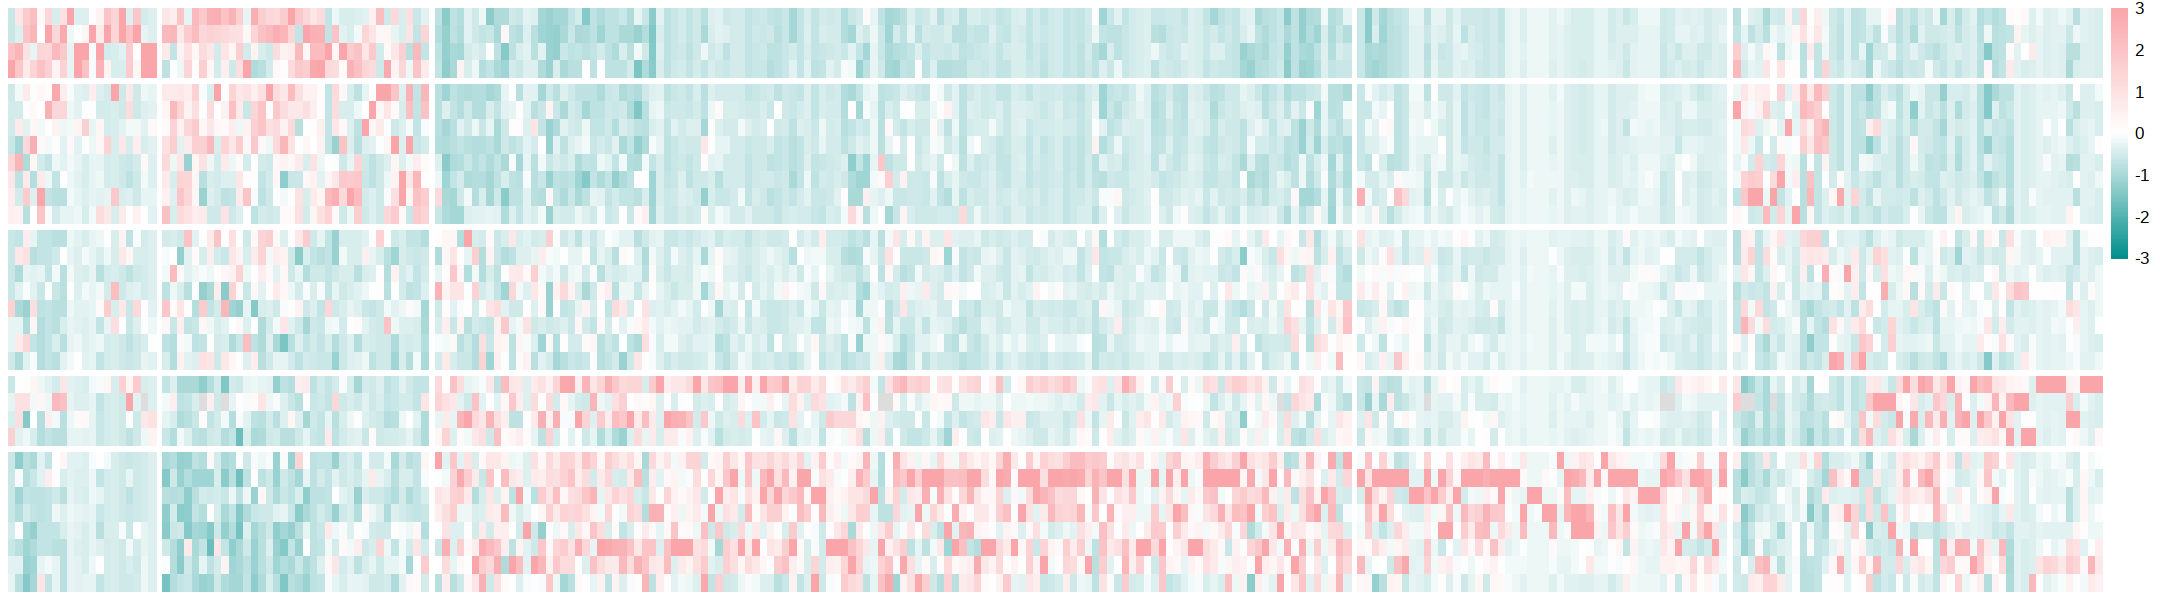

In [221]:
options(repr.plot.width = 18, repr.plot.height = 5)
res <- pheatmap(t(scaled_mat), breaks = seq(-3,3,length.out = 100),
                show_rownames = T,
                show_colnames = F,
                scale="none",
                gaps_col = c(20, 56, 180, 230),
                gaps_row = c(4, 12, 20, 24),
                cluster_cols = FALSE,
                cluster_rows = FALSE,
                color= colorRampPalette(c("#008F8C", "white","#F9A5A9"))(100),
)

#### Dot plot for cell-type-specific proportion changes

In [242]:
df_DA_main <- read.csv(file.path(input_folder, "DA_result_main_df_cell_proportion_aging.csv"), row.names = 1)

In [243]:
df_DA_main$sig_6v23 = ifelse(df_DA_main$qval_WT_06_23_corrected < 0.05 & abs(df_DA_main$LFC_23_over_06_WT) >= log2(2), 
                             "sig", "not_sig")

df_DA_main$plot_sig_6v23 = ifelse((df_DA_main$sig_6v23 == "sig") & (df_DA_main$LFC_23_over_06_WT <= log2(2)),
                                  "sig_down", "not_sig")
df_DA_main$plot_sig_6v23 = ifelse((df_DA_main$sig_6v23 == "sig") & (df_DA_main$LFC_23_over_06_WT >= log2(2)),
                                  "sig_up", df_DA_main$plot_sig_6v23)

df_DA_main$cap_LFC_6v23 = ifelse(df_DA_main$LFC_23_over_06_WT >= 3, 3, df_DA_main$LFC_23_over_06_WT)
df_DA_main$cap_LFC_6v23 = ifelse(df_DA_main$LFC_23_over_06_WT <= -3, -3, df_DA_main$cap_LFC_6v23)

In [244]:
df_DA_main <- df_DA_main %>% mutate(main_cell_type = map_chr(str_split(cell_type_id, "-"), ~ str_c(head(.x, -1), collapse = "-")),
                    organ_name = map_chr(str_split(cell_type_id, "-"), ~ tail(.x, 1)))

In [245]:
t(head(df_DA_main))

,1,2,3,4,5,6
X03_months.Prkdc,2.631940e-04,2.085590e-05,6.725766e-03,2.220110e-02,8.533777e-01,4.469915e-05
X03_months.Rag,2.287729e-04,1.283852e-05,5.853510e-03,2.776278e-02,7.895338e-01,1.319503e-04
X03_months.WT,3.767293e-04,1.524702e-05,7.649614e-03,2.896970e-02,8.032881e-01,1.205910e-02
X06_months.WT,5.401867e-04,4.278598e-05,6.798062e-03,3.245949e-02,7.914628e-01,1.776530e-02
X12_months.WT,1.982516e-04,4.511934e-05,4.153324e-03,2.369681e-02,8.652731e-01,1.397535e-02
X16_months.Prkdc,2.248488e-04,5.803191e-05,5.779417e-03,3.260864e-02,8.038137e-01,1.797667e-04
X16_months.Rag,7.979484e-04,3.852165e-05,3.102540e-03,2.220371e-02,8.790338e-01,1.244620e-04
X16_months.WT,7.840255e-05,1.730762e-05,5.162804e-03,3.003110e-02,8.207626e-01,2.272578e-02
X23_months.WT,0.000355840,0.008869499,0.006329538,0.039016536,0.643099344,0.063931448
cell_type_id,Adipocytes-Liver,Cacna1b positive cells-Liver,Cholangiocytes-Liver,Hepatic stellate cells-Liver,Hepatocytes-Liver,Lymphoid cells_B cells-Liver


In [246]:
df_DA_sub <- read.csv(file.path(input_folder, "DA_result_subcluster_df_cell_proportion_aging.csv"), row.names = 1)

In [247]:
df_DA_sub$sig_6v23 = ifelse(df_DA_sub$qval_WT_06_23_corrected < 0.05 & abs(df_DA_sub$LFC_23_over_06_WT) >= log2(2), 
                             "sig", "not_sig")

df_DA_sub$plot_sig_6v23 = ifelse((df_DA_sub$sig_6v23 == "sig") & (df_DA_sub$LFC_23_over_06_WT <= log2(2)),
                                  "sig_down", "not_sig")
df_DA_sub$plot_sig_6v23 = ifelse((df_DA_sub$sig_6v23 == "sig") & (df_DA_sub$LFC_23_over_06_WT >= log2(2)),
                                  "sig_up", df_DA_sub$plot_sig_6v23)

df_DA_sub$cap_LFC_6v23 = ifelse(df_DA_sub$LFC_23_over_06_WT >= 3, 3, df_DA_sub$LFC_23_over_06_WT)
df_DA_sub$cap_LFC_6v23 = ifelse(df_DA_sub$LFC_23_over_06_WT <= -3, -3, df_DA_sub$cap_LFC_6v23)

In [248]:
df_DA_sub <- df_DA_sub %>% mutate(subcluster = map_chr(str_split(cell_type_id, "-"), ~ str_c(head(.x, -1), collapse = "-")),
                    organ_name = map_chr(str_split(cell_type_id, "-"), ~ tail(.x, 1)))

In [252]:
df_DA_sub <- df_DA_sub %>% mutate(main_cell_type = map_chr(str_split(subcluster, "-"), ~ str_c(head(.x, -1), collapse = "-")))

In [253]:
t(head(df_DA_sub))

,1,2,3,4,5,6
X03_months.Prkdc,5.236013e-05,3.420369e-05,1.534431e-04,1.570495e-05,7.482118e-06,0.000000e+00
X03_months.Rag,1.866799e-05,4.947734e-05,6.781787e-05,7.368323e-05,1.912648e-05,0.000000e+00
X03_months.WT,1.094140e-05,9.158054e-05,1.058035e-04,1.261756e-04,4.222826e-05,0.000000e+00
X06_months.WT,1.061144e-04,1.884298e-04,1.439824e-04,7.135727e-05,3.030279e-05,2.304360e-06
X12_months.WT,2.983366e-05,1.072463e-04,4.092953e-05,8.757346e-06,1.148475e-05,0.000000e+00
X16_months.Prkdc,1.292885e-04,6.577489e-05,2.978543e-05,0.000000e+00,0.000000e+00,0.000000e+00
X16_months.Rag,6.768804e-04,8.254639e-05,5.503093e-06,0.000000e+00,3.301856e-05,0.000000e+00
X16_months.WT,0.000000e+00,7.399175e-05,0.000000e+00,0.000000e+00,4.410805e-06,0.000000e+00
X23_months.WT,6.014511e-05,8.977222e-05,1.035400e-04,1.012766e-05,9.225499e-05,2.096649e-03
cell_type_id,Adipocytes-0-Liver,Adipocytes-1-Liver,Adipocytes-2-Liver,Adipocytes-3-Liver,Adipocytes-4-Liver,Cacna1b positive cells-0-Liver


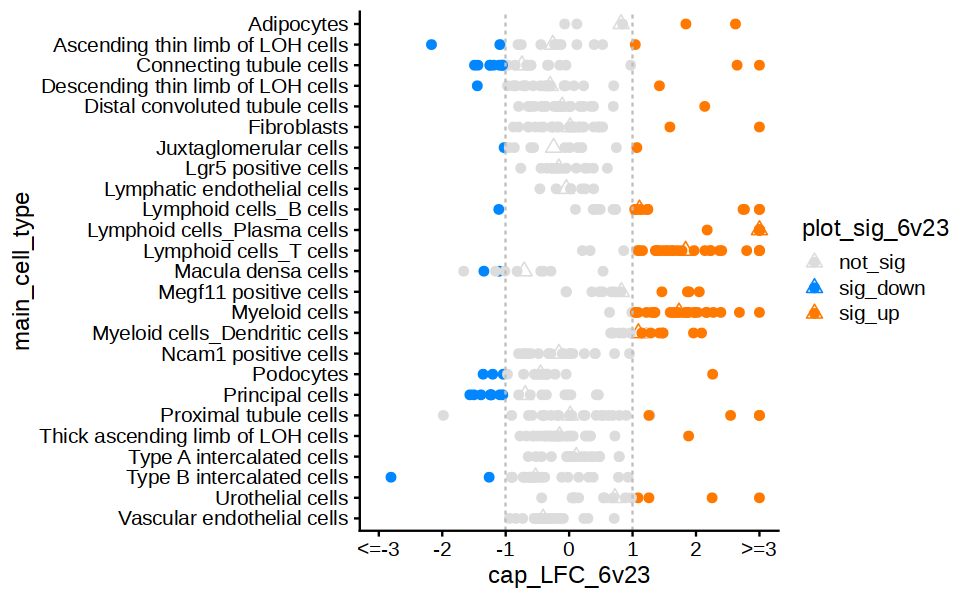

In [256]:
g1 <- ggplot() + 
    geom_point(data = df_DA_main %>% filter(organ_name=="Kidney"),
               aes(x = main_cell_type, y = cap_LFC_6v23, color = plot_sig_6v23),
               shape = 24, size = 3) +
    geom_point(data = df_DA_sub %>% filter(organ_name=="Kidney"),
               aes(x = main_cell_type, y = cap_LFC_6v23, color = plot_sig_6v23),
               shape = 19, size = 2) + 
    geom_hline(yintercept = c(-1,1), linetype = "dashed", color = "gray") + 
    scale_color_manual(values = c("not_sig" = "#DCDCDC", "sig_up" = "#FF7900", "sig_down" = "#0086FF")) + 
    coord_flip() + 
    scale_x_discrete(limits = rev) + 
    scale_y_continuous(breaks = seq(-3, 3, by = 1), limits = c(-3,3),
                       labels = c("<=-3", "-2", "-1", "0", "1", "2", ">=3")) + 
    theme_cowplot() + 
    theme(legend.position = "right") 
options(repr.plot.width=8, repr.plot.height=5)
g1

#### Stacked bar plot for proportion of cell types from different lineage/organ

In [279]:
df_plot <- read.csv(file.path(input_folder, "df_aging_associated_subcluster_by_organ.csv"))

In [283]:
df_plot$organ_name <- factor(df_plot$organ_name, levels = rev(c('Lung', 'Heart', 'Liver', 'Kidney','Muscle',
                                                                'Stomach', 'Duodenum', 'Jejunum', 'Ileum', 'Colon',
                                                                'BAT', 'iWAT', 'gWAT')))

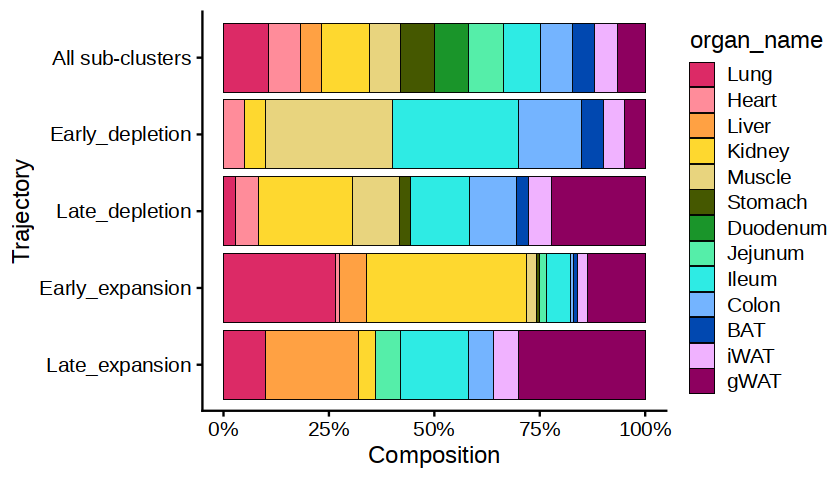

In [284]:
options(repr.plot.width = 7, repr.plot.height = 4)
g1 <- ggplot(data = df_plot %>% filter(aging_trajectory != "Transition"), 
       aes(fill=organ_name ,x=aging_trajectory, y=subcluter_number))+
    geom_bar(position='fill', stat='identity', size=0.2, colour="black") +
    scale_fill_manual(values = main_cluster_palette_list$organ_palette_updated)+
    coord_flip() +
    theme_half_open() +
    scale_x_discrete(limits = rev(c('All sub-clusters','Early_depletion','Late_depletion','Early_expansion','Late_expansion'))) +
    scale_y_continuous(labels = scales::percent_format(scale = 100)) +
    labs(y = "Composition", x = "Trajectory") +
    theme(plot.title = element_text(hjust = 0.5, vjust = 0.5)) +
    guides(fill = guide_legend(reverse = TRUE))
g1

#### Stacked bar plot with flows for cell population dynamics in different lineage/organ across age groups

In [ ]:
# ## Immune subtype number per organ per age
# df_immune_cell_counts_per_organ <- df_cell_immune %>%
#     filter(immune_main_type == "T cells and innate lymphoid cells", genotype == "WT") %>%
#     group_by(organ, immune_annotation, age_group) %>% 
#     summarise(cell_type_count = n())

# ## Total cell number per organ per ID per age
# df_organ_total_number <- df_cell_all %>%
#     filter(genotype == "WT") %>%
#     group_by(organ_name, age_group) %>%
#     summarise(organ_cell_count = n())

# df_summary_by_age <- df_immune_cell_counts_per_organ %>%
#     left_join(df_organ_total_number %>% select(organ = organ_name, age_group, organ_cell_count), by = c("organ", "age_group")) %>%
#     mutate(normalized_prop = cell_type_count/organ_cell_count)

In [277]:
df_summary_by_age <- read.csv(file.path(input_folder, "df_immune_subtype_prop_normalized.csv"), row.names = 1)

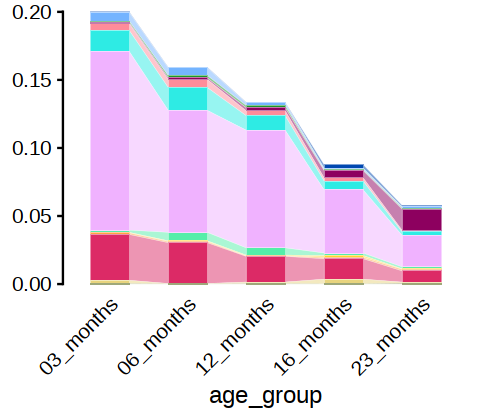

In [278]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
target_cell_type = "CD4+ naive T cells"
df_plot <- df_summary_by_age %>% filter(immune_annotation == target_cell_type)

g1 <- ggplot(df_plot, aes(x = age_group, y = normalized_prop, fill = organ)) +
    geom_flow(aes(alluvium = organ), alpha= .5, color = "white",
            curve_type = "linear", size = 0.1, width = .5) +
    geom_col(width = .5, color = "white", size = 0.1) +
    scale_y_continuous(NULL, expand = c(0,0)) +
    scale_color_manual(values = main_cluster_palette_list$organ_palette_updated) +
    scale_fill_manual(values = main_cluster_palette_list$organ_palette_updated) +
    theme_cowplot() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "none",
            axis.ticks.x = element_blank(), 
            axis.line.x = element_blank()) 
g1

#### Volcano plot for visualizing differentially aboundant cell types

In [258]:
df_DA_sub <- read.csv(file.path(input_folder, "DA_result_subcluster_df_cell_proportion_aging.csv"), row.names = 1)

In [259]:
t(head(df_DA_sub))

,1,2,3,4,5,6
X03_months.Prkdc,5.236013e-05,3.420369e-05,1.534431e-04,1.570495e-05,7.482118e-06,0.000000e+00
X03_months.Rag,1.866799e-05,4.947734e-05,6.781787e-05,7.368323e-05,1.912648e-05,0.000000e+00
X03_months.WT,1.094140e-05,9.158054e-05,1.058035e-04,1.261756e-04,4.222826e-05,0.000000e+00
X06_months.WT,1.061144e-04,1.884298e-04,1.439824e-04,7.135727e-05,3.030279e-05,2.304360e-06
X12_months.WT,2.983366e-05,1.072463e-04,4.092953e-05,8.757346e-06,1.148475e-05,0.000000e+00
X16_months.Prkdc,1.292885e-04,6.577489e-05,2.978543e-05,0.000000e+00,0.000000e+00,0.000000e+00
X16_months.Rag,6.768804e-04,8.254639e-05,5.503093e-06,0.000000e+00,3.301856e-05,0.000000e+00
X16_months.WT,0.000000e+00,7.399175e-05,0.000000e+00,0.000000e+00,4.410805e-06,0.000000e+00
X23_months.WT,6.014511e-05,8.977222e-05,1.035400e-04,1.012766e-05,9.225499e-05,2.096649e-03
cell_type_id,Adipocytes-0-Liver,Adipocytes-1-Liver,Adipocytes-2-Liver,Adipocytes-3-Liver,Adipocytes-4-Liver,Cacna1b positive cells-0-Liver


In [268]:
df_plot <- df_DA_sub %>% select(cell_type_id, LFC_23_over_06_WT, qval_WT_06_23_corrected)
df_plot$color_class = "Below_cutoff" 
df_plot$color_class <- ifelse(df_plot$qval_WT_06_23_corrected < 0.05 &
                              df_plot$LFC_23_over_06_WT > log2(2),
                              "23_months", df_plot$color_class)
df_plot$color_class <- ifelse(df_plot$qval_WT_06_23_corrected < 0.05 &
                              df_plot$LFC_23_over_06_WT < -log2(2),
                              "06_months", df_plot$color_class)

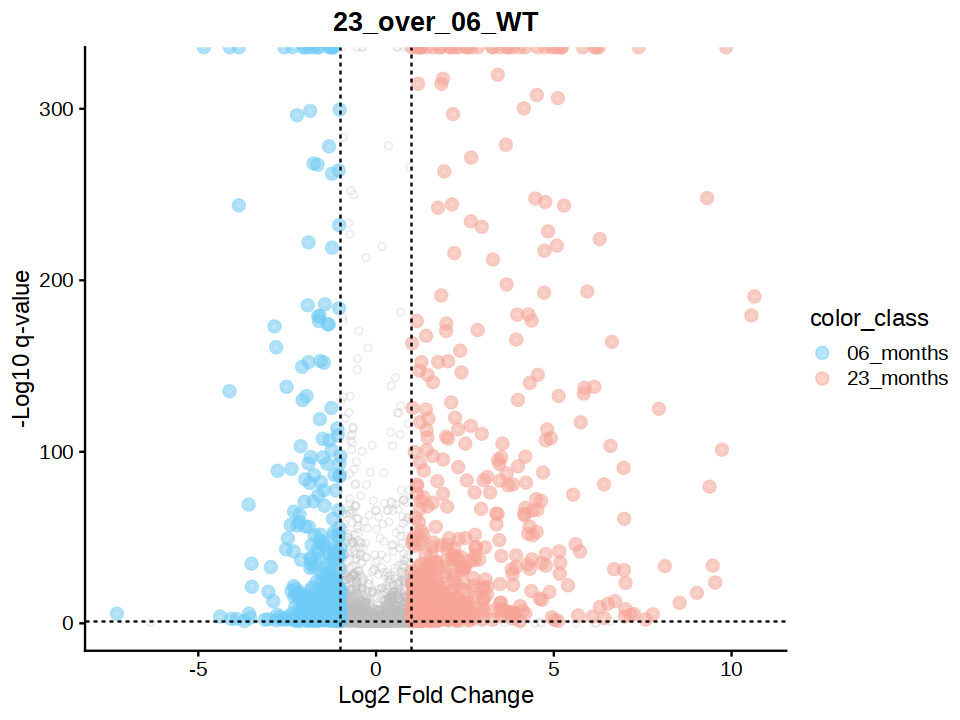

In [269]:
options(repr.plot.width=8, repr.plot.height=6)
g1 <- ggplot() +
    geom_point(data = df_plot, 
               aes(x = LFC_23_over_06_WT, y = -log10(qval_WT_06_23_corrected)), 
               color = "grey", alpha = 0.3, shape = 1) +
    geom_point(data = df_plot %>% filter(color_class != "Below_cutoff"), 
               aes(x = LFC_23_over_06_WT, y = -log10(qval_WT_06_23_corrected), color = color_class), 
               alpha = 0.5, size = 3) +
    scale_color_manual(values = main_cluster_palette_list$age_palette_2) +
    labs(x = "Log2 Fold Change", y = "-Log10 q-value", title = "23_over_06_WT") +
    geom_vline(xintercept = c(-log2(2), log2(2)), linetype = "dashed") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    #ylim(0,20) +
    theme_cowplot() +
    theme(plot.title = element_text(hjust = 0.5))
g1

### Molecular level analysis

#### UMAP visualization of targeted gene expression in each cell

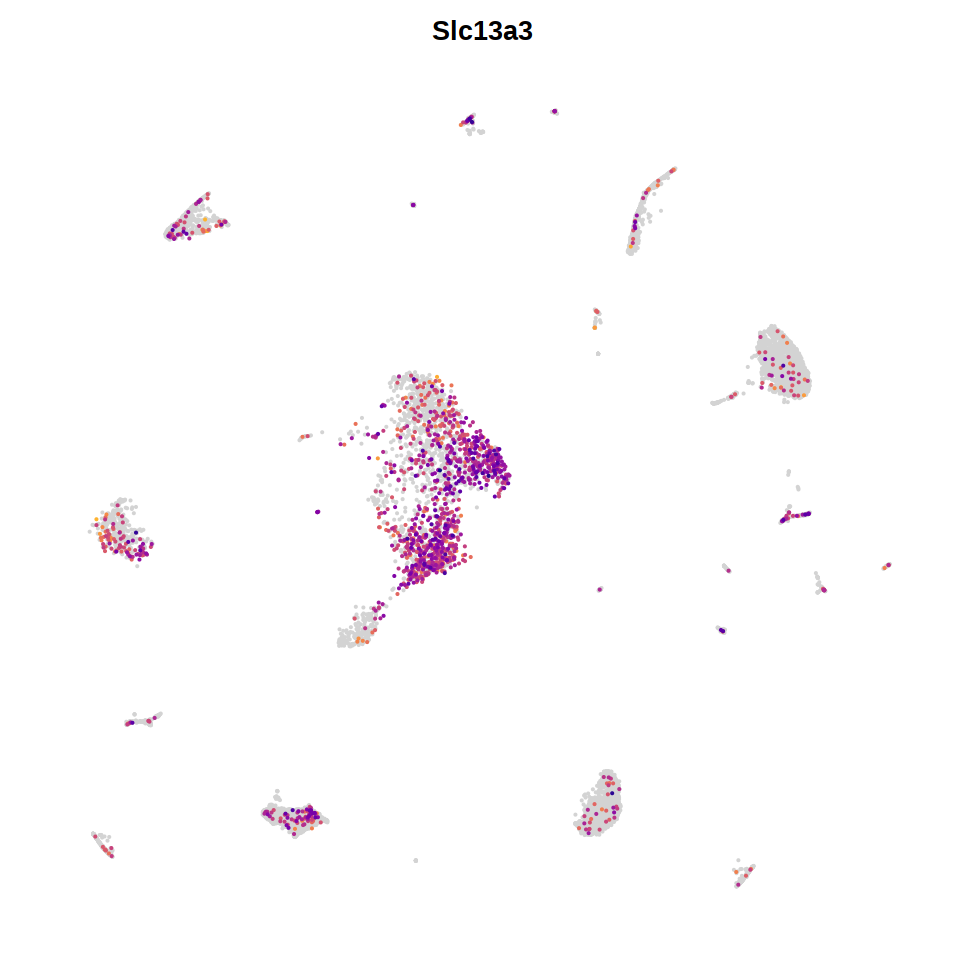

In [78]:
g1 <- FeaturePlot_scCustom(seurat_object = seu, features = "Slc13a3")+
    theme_cowplot() +
    theme(plot.title = element_text(hjust = 0.5),
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank(),
          legend.position = "none")
options(repr.plot.width = 8, repr.plot.height = 8)
g1

####  UMAP visualization of targeted gene expression density

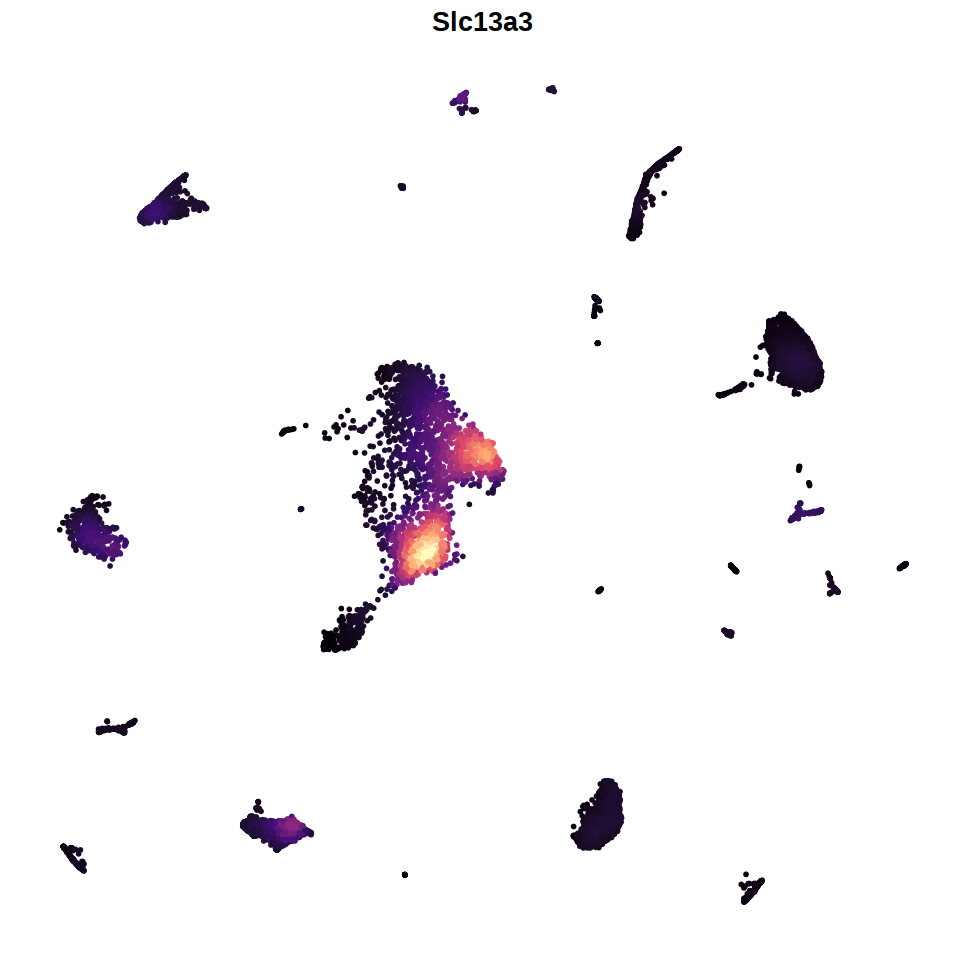

In [79]:
g1 <- Plot_Density_Custom(seurat_object = seu, features = "Slc13a3")+
    theme_cowplot() +
    theme(plot.title = element_text(hjust = 0.5),
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank(),
          legend.position = "none")
options(repr.plot.width = 8, repr.plot.height = 8)
g1

#### Violin plot for targeted genes expression across cell types/conditions

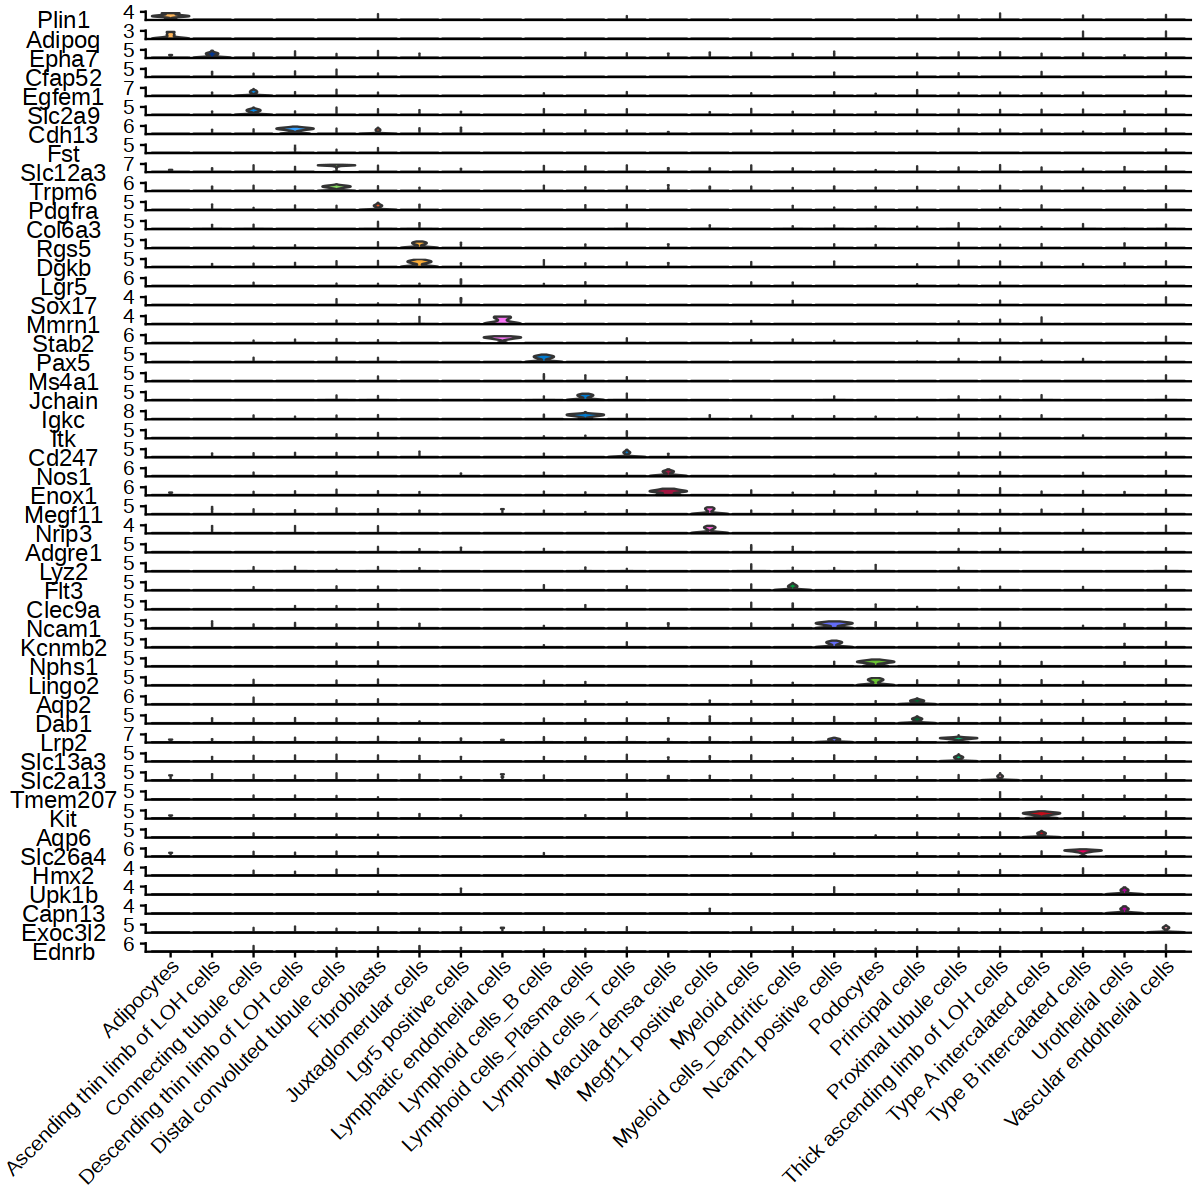

In [89]:
options(repr.plot.width = 10, repr.plot.height = 10)
g1 <- Stacked_VlnPlot(seurat_object = seu, features = cell_markers, plot_spacing = 0.05, x_lab_rotate = TRUE,
                     colors_use = cell_type_colors) +
    theme(legend.position = "none")
g1

#### Dot plot for targeted gene expression across cell types/conditions

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


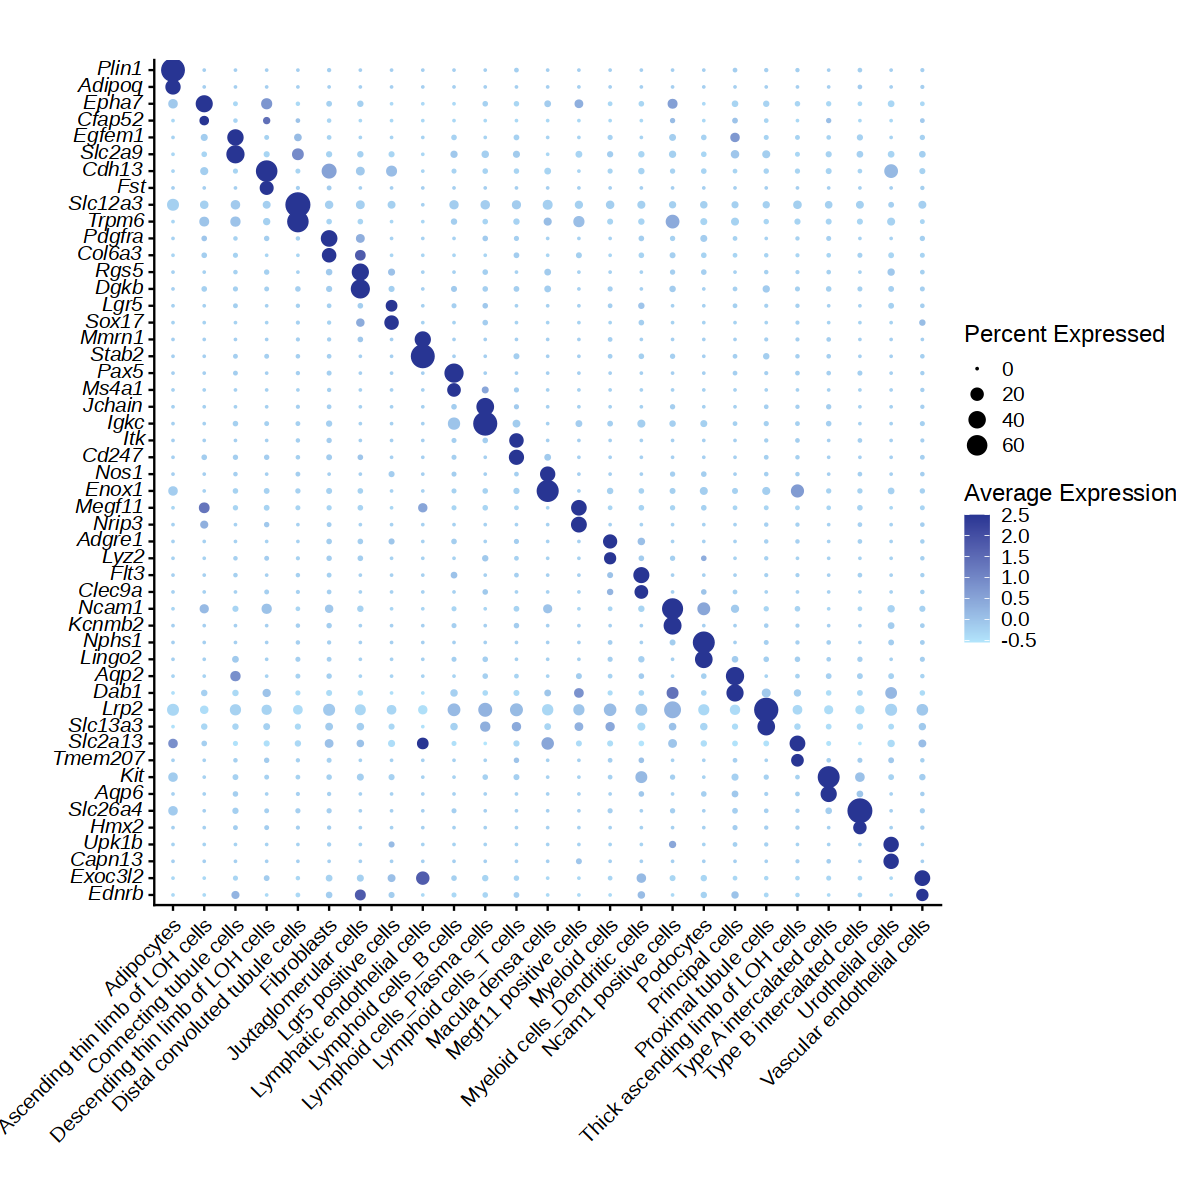

In [102]:
g1 <- DotPlot(object = seu, features = rev(cell_markers), cols = c("#B3E5FC","#283593")) + 
    labs(x='',y='')+
    coord_flip() + 
    scale_size_area(breaks=c(0,20,40,60)) +
    scale_x_discrete(labels = paste0("<i>",rev(cell_markers), "</i>")) +
    theme(axis.text.y = element_markdown(),
          axis.text.x = element_text(angle = 45, hjust = 1),
          plot.margin = unit(c(0.5, 0.2, 0.2, 0.2),"inches"))
options(repr.plot.width=10, repr.plot.height=10)
g1

#### Heatmap for targeted gene expression across cell types/conditions

In [292]:
exprs_by_main_cell_type <- cds_cell_type_exprs(cds = cds, cds$Main_cell_type)

In [293]:
all(rownames(exprs_by_main_cell_type) == fData(cds)$gene_id)
rownames(exprs_by_main_cell_type) = make.names(fData(cds)$gene_short_name, unique = TRUE)

[1] TRUE

In [294]:
df_plot <- t(exprs_by_main_cell_type[cell_markers, ])

In [295]:
t(head(df_plot))

50 x 6 Matrix of class "dgeMatrix"
        Adipocytes Ascending thin limb of LOH cells Connecting tubule cells
Plin1     4.513012                        0.0000000               0.0000000
Adipoq    3.199873                        0.0000000               0.0000000
Epha7     1.593627                        3.9672166               0.3793347
Cfap52    0.000000                        2.2133008               0.1091485
Egfem1    0.000000                        1.1698772               5.0652670
Slc2a9    0.000000                        0.5541910               4.4048265
Cdh13     0.000000                        1.9350309               0.2971254
Fst       0.000000                        0.0000000               0.0000000
Slc12a3   2.179642                        1.9350309               3.6561564
Trpm6     0.000000                        2.3633904               2.5097737
Pdgfra    0.000000                        1.3767816               0.1091485
Col6a3    0.000000                        0.5541910  

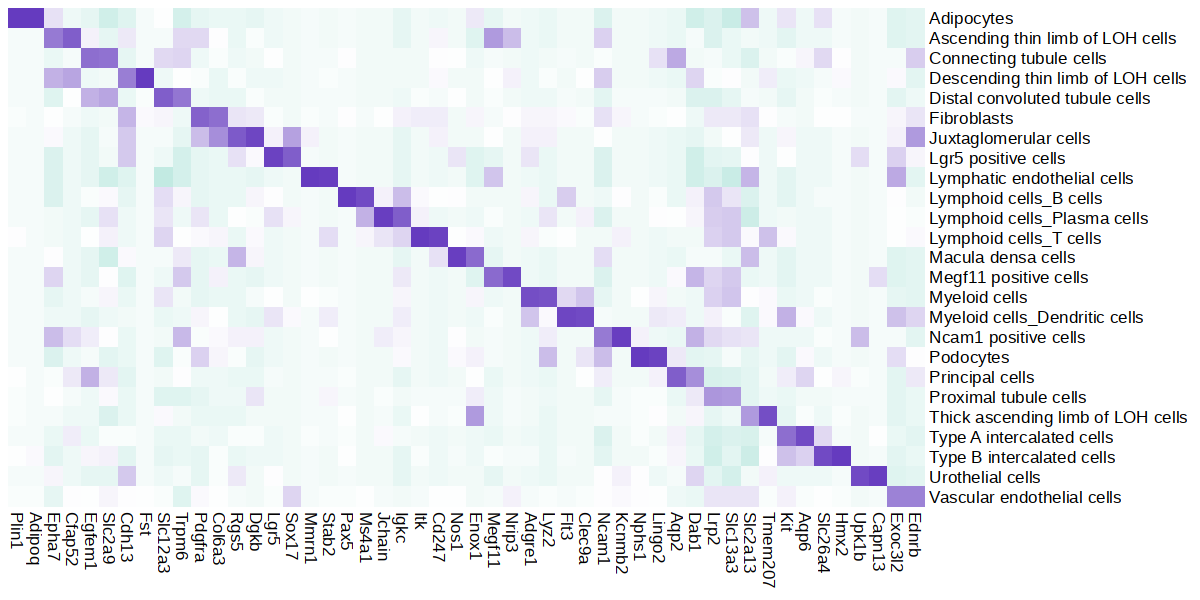

In [296]:
options(repr.plot.width = 10, repr.plot.height = 5)
res <- pheatmap(df_plot, 
                scale = "column",
                show_rownames = T, show_colnames = T,
                border_color = NA,color = colorRampPalette(c("#48C0AA", "#FFFFFF", "#653BBF"))(100),
                legend = FALSE, annotation_legend = FALSE,
                cluster_rows = F,
                cluster_cols = F)

#### Boxplot for target gene expression

In [148]:
cds$Conditions_ID <- paste(cds$Organ_name, cds$Age_group, cds$Sex, cds$ID, sep = "-")
exprs_by_Conditions_ID = cds_cell_type_exprs(cds, cds$Conditions_ID)
all(rownames(exprs_by_Conditions_ID) == fData(cds)$gene_id)
rownames(exprs_by_Conditions_ID) = make.names(fData(cds)$gene_short_name, unique = TRUE)

[1] TRUE

In [162]:
target_gene = "Slc13a3"
target_agg_exprs = exprs_by_Conditions_ID
df_plot <- data.frame(target_agg_exprs[target_gene,])
df_plot$Conditions <- rownames(df_plot)
df_plot <- df_plot %>%
    select(expression = colnames(df_plot)[1], Conditions) %>%
    separate(Conditions, into = c("Organ", "Age", "Sex", "ID"), sep = "-", remove = FALSE)

In [154]:
head(df_plot)

,expression,Conditions,Organ,Age,Sex,ID
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
Kidney-03_months-Female-44,3.129142,Kidney-03_months-Female-44,Kidney,03_months,Female,44
Kidney-03_months-Female-45,2.737919,Kidney-03_months-Female-45,Kidney,03_months,Female,45
Kidney-03_months-Male-42,2.643715,Kidney-03_months-Male-42,Kidney,03_months,Male,42
Kidney-03_months-Male-43,2.771037,Kidney-03_months-Male-43,Kidney,03_months,Male,43
Kidney-06_months-Female-13,2.400580,Kidney-06_months-Female-13,Kidney,06_months,Female,13
Kidney-06_months-Female-14,2.733576,Kidney-06_months-Female-14,Kidney,06_months,Female,14


In [156]:
Age_gene_color_code <- c(
    "03_months" = "#BCBCFF",
    "06_months" = "#9589C1",
    "12_months" = "#6F5692",
    "16_months" = "#50216F",
    "23_months" = "#4A1259"
)

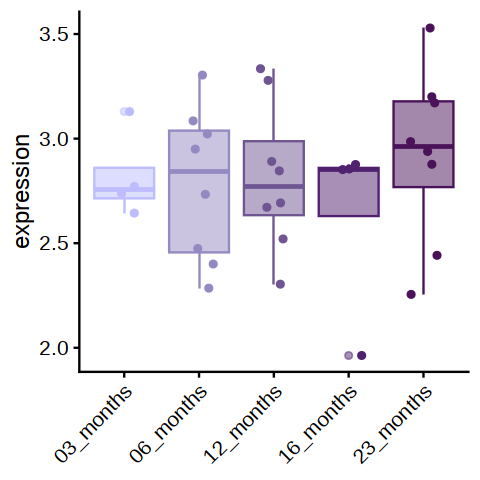

In [161]:
g1 <- ggplot(df_plot, aes(x = Age, y = expression, color = Age)) +
      geom_boxplot(aes(fill = Age), alpha = 0.5, width = 0.8) +  
      geom_jitter(width = 0.2) +                                 
      theme_cowplot() +                                          
      scale_color_manual(values = Age_gene_color_code) +         
      scale_fill_manual(values = Age_gene_color_code) +          
      theme(axis.text.x = element_text(angle = 45, hjust = 1),   
            axis.title.x = element_blank(),                      
            legend.position = "none",                            
            plot.title = element_text(hjust = 0.5))             
options(repr.plot.width = 4, repr.plot.height = 4)
g1

#### Lollipop plot for the count of differentially expressed genes

In [289]:
df_plot <- read.csv(file.path(input_folder, "df_DE_num_count_Kidney.csv"), row.names = 1)

In [290]:
t(head(df_plot))

,1,2,3,4,5,6
main_cell_type,Adipocytes,Adipocytes,Ascending thin limb of LOH cells,Ascending thin limb of LOH cells,Connecting tubule cells,Connecting tubule cells
age,06_months,23_months,06_months,23_months,06_months,23_months
count,-51,32,-95,94,-76,45


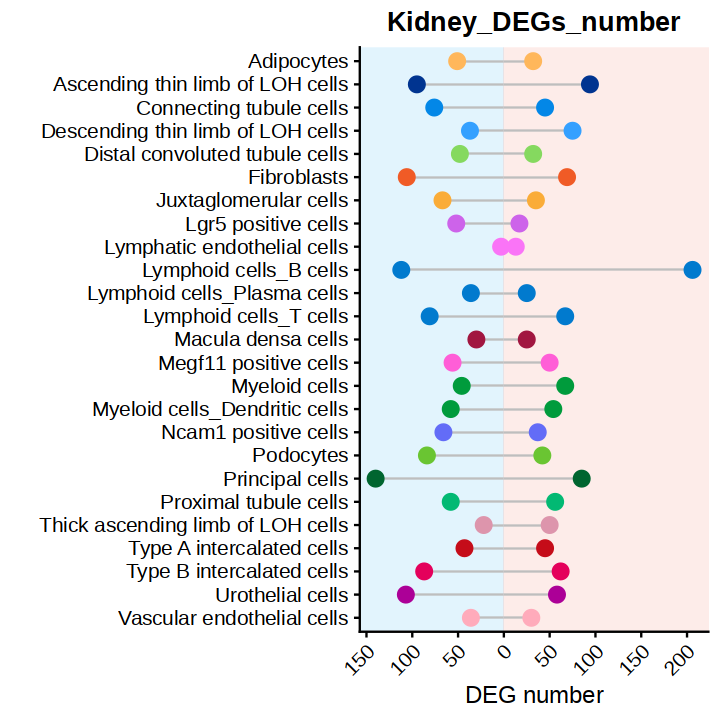

In [291]:
df_plot$main_cell_type <- factor(df_plot$main_cell_type, 
                                 levels = rev(sort(unique(df_plot$main_cell_type))))
g1 <- ggplot(df_plot, aes(x = count, y = main_cell_type, color = main_cell_type)) +
    geom_rect(data = data.frame(xmin = c(-Inf, 0), xmax = c(0, Inf), 
                                ymin = -Inf, ymax = Inf, fill = c("06_months", "23_months") ), 
              aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, fill = fill), 
              inherit.aes = FALSE, alpha = 0.2) +
    geom_segment(aes(x = 0, y = main_cell_type, xend = count, yend = main_cell_type), color = "grey") +
    geom_point(size = 4) +
    scale_color_manual(values = main_cluster_palette_list[['Kidney']]) +
    scale_fill_manual(values = main_cluster_palette_list$age_palette_2) +
    scale_x_continuous(position = "bottom", labels = abs, 
                     breaks = scales::pretty_breaks(n = 10)) +
    labs(x = "DEG number", y = "", title = "Kidney_DEGs_number") +
    theme_cowplot() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          plot.title = element_text(hjust = 0.5),
          legend.position = "none")

options(repr.plot.width=6, repr.plot.height=6)
g1